## Bayesian Correlation with PyMC

In this notebook, I show how to determine a correlation coefficient within the Bayesian framework both in a simply and a robust way. The correlation can be seen as a direct alternative to the traditional Pearson correlation coefficient.

The model and code shown here is motivated by the following blog posts and the book "Bayesian Cognitive Modeling":

* http://www.sumsar.net/blog/2013/08/bayesian-estimation-of-correlation/
* http://www.sumsar.net/blog/2013/08/robust-bayesian-estimation-of-correlation/
* http://bayesmodels.com/

My main contribution here is to show how do apply the model with Python and PyMC.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 

### Model

First, let us start with defining our model both for the classic way of using a multivariate normal distribution as well as for the robust way that utilizes a multivariate student t-distribution.

In [2]:
import pymc as pymc
from pymc import Normal, Uniform, MvNormal, Exponential
from numpy.linalg import inv, det
from numpy import log, pi, dot
import numpy as np
from scipy.special import gammaln

def _model(data, robust=False):
    # priors might be adapted here to be less flat
    mu = Normal('mu', 0, 0.000001, size=2)
    sigma = Uniform('sigma', 0, 1000, size=2)
    rho = Uniform('r', -1, 1)
    
    # we have a further parameter (prior) for the robust case
    if robust == True:
        nu = Exponential('nu',1/29., 1)
        # we model nu as an Exponential plus one
        @pymc.deterministic
        def nuplus(nu=nu):
            return nu + 1
    
    @pymc.deterministic
    def precision(sigma=sigma,rho=rho):
        ss1 = float(sigma[0] * sigma[0])
        ss2 = float(sigma[1] * sigma[1])
        rss = float(rho * sigma[0] * sigma[1])
        return inv(np.mat([[ss1, rss], [rss, ss2]]))
    
    if robust == True:
        # log-likelihood of multivariate t-distribution
        @pymc.stochastic(observed=True)
        def mult_t(value=data.T, mu=mu, tau=precision, nu=nuplus):
            k = float(tau.shape[0])
            res = 0
            for r in value:
                delta = r - mu
                enum1 = gammaln((nu+k)/2.) + 0.5 * log(det(tau))
                denom = (k/2.)*log(nu*pi) + gammaln(nu/2.)
                enum2 = (-(nu+k)/2.) * log (1 + (1/nu)*delta.dot(tau).dot(delta.T))
                result = enum1 + enum2 - denom
                res += result[0]
            return res[0,0]
        
    else:
        mult_n = MvNormal('mult_n', mu=mu, tau=precision, value=data.T, observed=True)
    
    return locals()
    
def analyze(data, robust=False, plot=True):
    model = pymc.MCMC(_model(data,robust)) 
    model.sample(50000,25000) 

    print
    if plot:
        pymc.Matplot.plot(model) 
    
    return model

### Data

Let us define some data.

In [3]:
import numpy as np
x = np.array([525., 300., 450., 300., 400., 500., 550., 125., 300., 400., 500., 550.])
y = np.array([250., 225., 275., 350., 325., 375., 450., 400., 500., 550., 600., 525.])
data = np.array([x, y])

### Inference

And now, we can do the inference. First, with the classic (non-robust) model.

 [-----------------100%-----------------] 50000 of 50000 complete in 16.9 sec
Plotting r
Plotting precision_0_0
Plotting precision_0_1
Plotting precision_1_0
Plotting precision_1_1
Plotting sigma_0
Plotting sigma_1
Plotting mu_0
Plotting mu_1


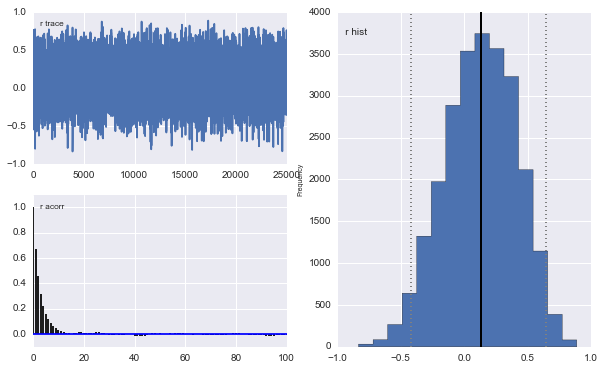

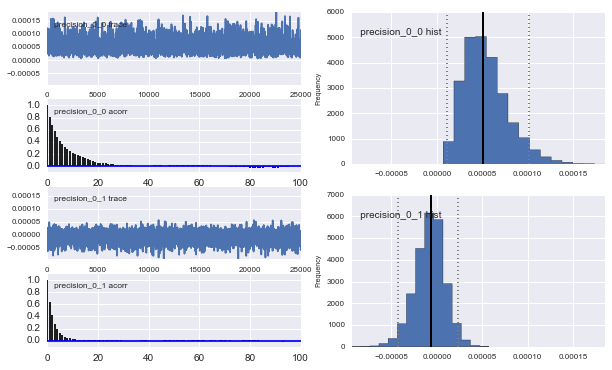

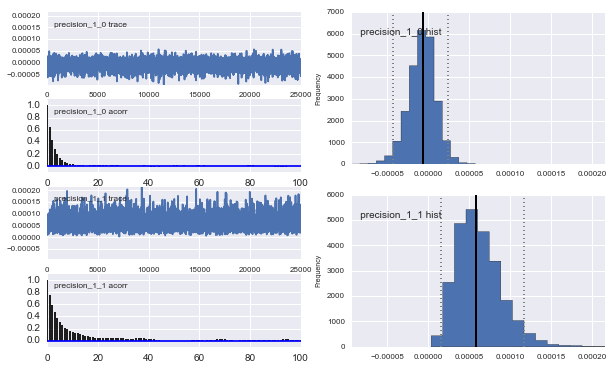

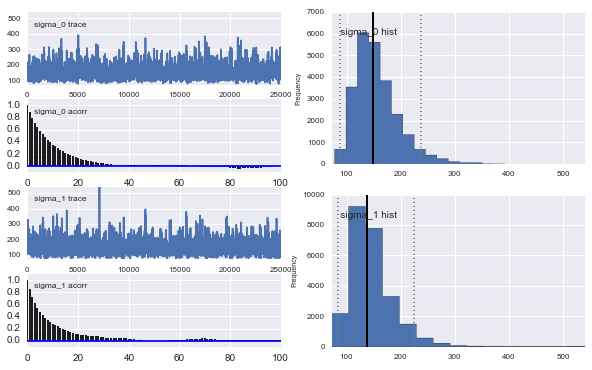

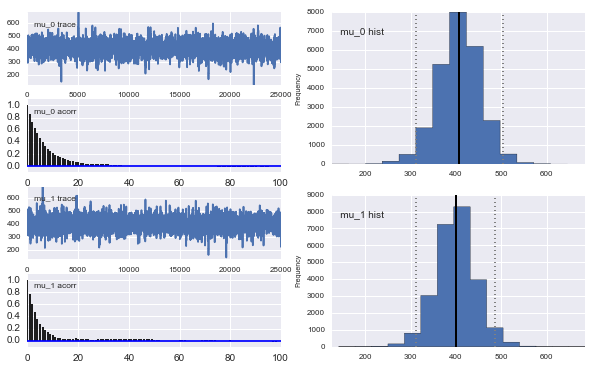

In [4]:
model = analyze(data)

In [5]:
print model.stats()['r']['mean']
print model.stats()['r']['95% HPD interval']

0.128117548483
[-0.41960463  0.64332013]


So the mean correlation (rho) is around 0.13. However, when we take a look at the histogram of the marginal posterior for rho, we can see that the frequency of distinct values for rho are pretty wide. We can characterize this with the 95% HDP (highest probability density) interval---also called credible interval---which is [-0.42  0.64]. Thus, with this HDP, we can get a very thorough view regarding the distribution of the parameters for rho. While the mean correlation is slightly positive, we cannot rule out a negative correlation or a non-existing correlation (rho=0). Actually, we can just count the number of times rho is positive by looking at the trace of rho. This can be seen as a Bayesian way of accepting or rejecting hypotheses (so-called ROPEs). A discussion about this can be found in one of John Kruschke's <a href="http://doingbayesiandataanalysis.blogspot.de/2013/08/how-much-of-bayesian-posterior.html">blog posts</a>.

In [6]:
(model.trace('r')[:]>0.05).mean()

0.61136000000000001

As a result, we see that only around 61% of all values of the posterior are above 0.05. Thus, we only see mediocre evidence for a positive correlation in the data.

Let us now relax this assumption and just determine what the probability is that there is no correlation at all (regardless negative or positive) with a ROPE of [0.05,0.05].

In [7]:
((model.trace('r')[:]<0.05) & (model.trace('r')[:]>-0.05)).mean()

0.12236

We can only see week evidence that there is no correlation at all. Thus, the probability that there is a negative correlation is around 27%. Overall, the inference and our inspection of the marginal posterior reveals that there might be a slight tendency towards a positive correlation, but we are pretty unsure about it. We might want to gather further data to supplement our inference.

Let us now compare these results to a classic Pearson correlation coefficient:

In [8]:
from scipy.stats.stats import pearsonr
pearsonr(x,y)

(0.1746680664120466, 0.58716519218300223)

Not surprisingly, our Bayesian rho values is very similar to the one determined by the Pearson correlation coefficient. The p-value states that we cannot reject the null hypothesis that there is no correlation (two-sided).

## More data

Let us take a look at a further dataset taken from the <a href="http://www.sumsar.net/blog/2013/08/bayesian-estimation-of-correlation/">blog post</a> by Rasmus Bååth linked at the beginning of this post. 

In [9]:
s = [9.92,94,9.94,79,9.97,78,9.93,83,9.90,77,9.93,76,10.00,74,9.97,87,10.00,86,10.01,83,10.08,75,10.09,74,10.15,92,10.15,69,10.17,79,10.17,71,10.19,80,10.30,80,10.31,77,10.34,87]
x = [float(a) for i,a in enumerate(s) if i % 2 == 0]
y = [float(a) for i,a in enumerate(s) if i % 2 != 0]
data = np.array([x, y])

We again do inference with the simple model.

In [10]:
model = analyze(data,plot=False)

 [-----------------100%-----------------] 50000 of 50000 complete in 20.8 sec


In [11]:
print model.stats()['r']['mean']
print model.stats()['r']['95% HPD interval']

-0.0907941631
[-0.49802096  0.34042248]


We can see a slight negative correlation, however the 95% HDP interval again is very wide and also includes a correlation zero and positive correlation. The Pearson correlation shows similar results, but claims no statistical significance.

In [12]:
from scipy.stats.stats import pearsonr
pearsonr(x,y)

(-0.10965237912730059, 0.64537479933386654)

What happens, if we add an outlier to the data as elaborated in the follow-up <a href="http://www.sumsar.net/blog/2013/08/robust-bayesian-estimation-of-correlation/">blog post</a> by Rasmus Bååth.

In [13]:
x.append(9.5)
y.append(115.)
data = np.array([x, y])

In [14]:
model = analyze(data,plot=False)

 [-----------------100%-----------------] 50000 of 50000 complete in 22.0 sec


In [15]:
print model.stats()['r']['mean']
print model.stats()['r']['95% HPD interval']

-0.51290073427
[-0.80040565 -0.19095111]


Suddenly, only this one data point, changed the results drastically. The inference now indicates a strong negative correlation and the 95% HDP interval contains only negative correlations. Here, we would for sure claim a strong belief in negative correlation according to our analysis.

In [16]:
from scipy.stats.stats import pearsonr
pearsonr(x,y)

(-0.56990140833523373, 0.0069939604634016196)

Not surprisingly, the Pearson correlation again agrees with our Bayesian inference and states the correlation as significant. This is not surprising, as the Pearson correlation is very non-robust to non-normality of the data as it is a measure of linear dependence. The same happends of course with our Bayesian model that models the data with a normal distribution.

Thus, we make our model more robust as elaborated in cited <a href="http://www.sumsar.net/blog/2013/08/robust-bayesian-estimation-of-correlation/">blog post</a>. What we actually want, is a model that assumes that the majority of the data is normally distributed, but still allows outliers to exist. Within our Bayesian framework, we can choose any model for the likelihood. In that case, a robust model is the multivariate student t-distribution. For a detailed discussion please refer to corresponding <a href="http://www.sumsar.net/blog/2013/08/robust-bayesian-estimation-of-correlation/">blog post</a>.

Now, let us apply the robust model (multivariate student t-distribution).

 [-----------------100%-----------------] 50000 of 50000 complete in 274.1 sec
Plotting precision_0_0
Plotting precision_0_1
Plotting precision_1_0
Plotting precision_1_1
Plotting sigma_0
Plotting sigma_1
Plotting nuplus
Plotting nu
Plotting mu_0
Plotting mu_1
Plotting r


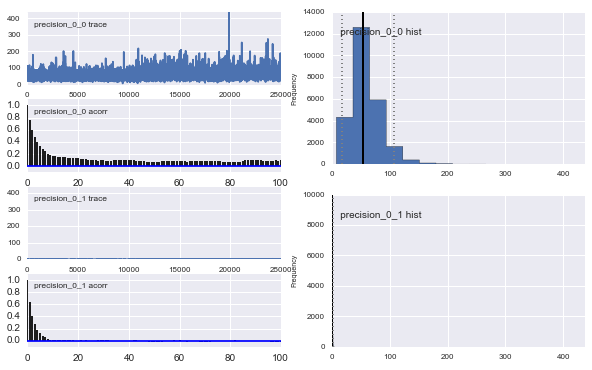

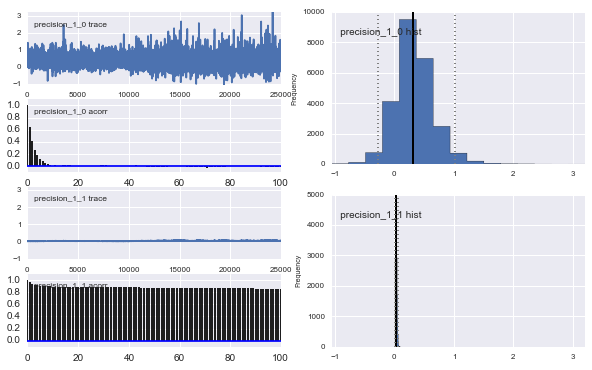

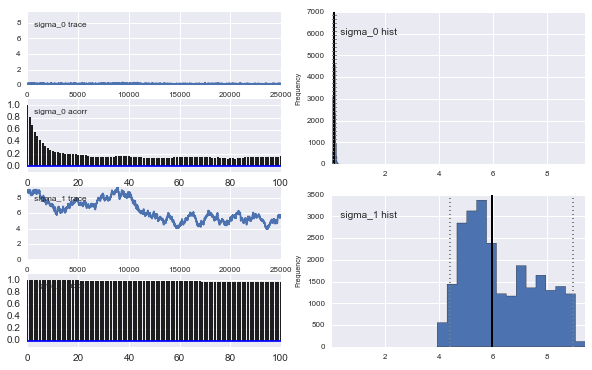

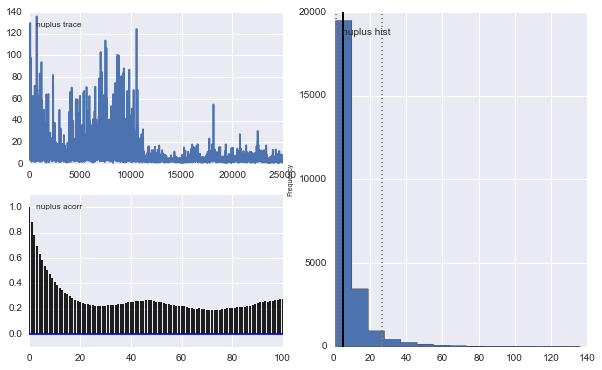

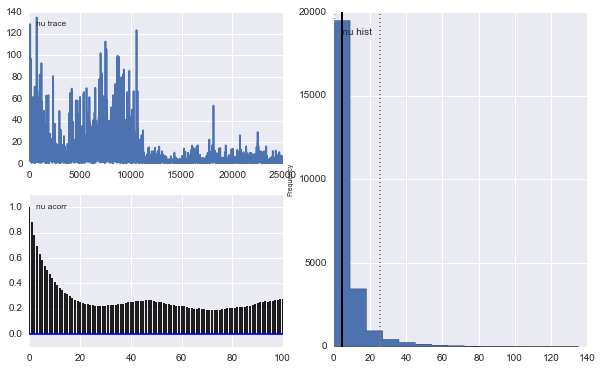

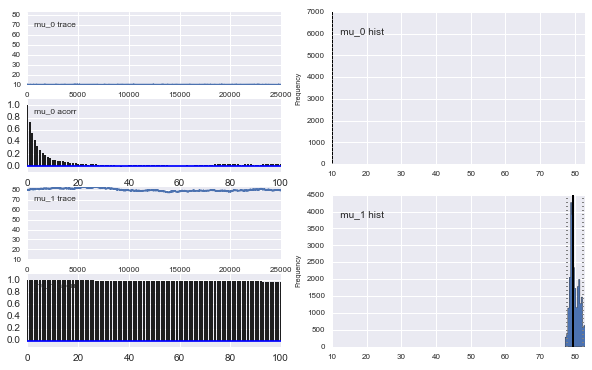

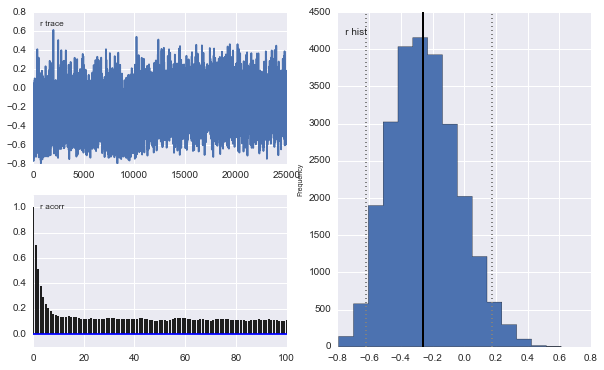

In [17]:
# this takes a while with many iterations as the likelihood calculation is not optimized
model = analyze(data, robust=True)

In [18]:
print model.stats()['r']['mean']
print model.stats()['r']['95% HPD interval']

-0.24840714476
[-0.61975082  0.17686788]


This estimation looks much more reasonable and is closer to our original estimation for the data with no outlier using the multivariate normal model.

Let us take a look at the marginal of nu:

In [19]:
print model.stats()['nu']['mean']
print model.stats()['nu']['95% HPD interval']

7.52515944508
[  1.87952517e-02   2.54122644e+01]


Here, we can see that nu is quite small, which indicates no strict normality of the data; the higher nu is, the more the multivariate t-distribution resembles the multivariate normal distribution.

Due to this flexibility of the multivariate t-distribution, we can always apply it when doing Bayesian correlation inference.